<a href="https://colab.research.google.com/github/pranjall702/Fraud-Detection-Machine-Learning-XGBoost/blob/main/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

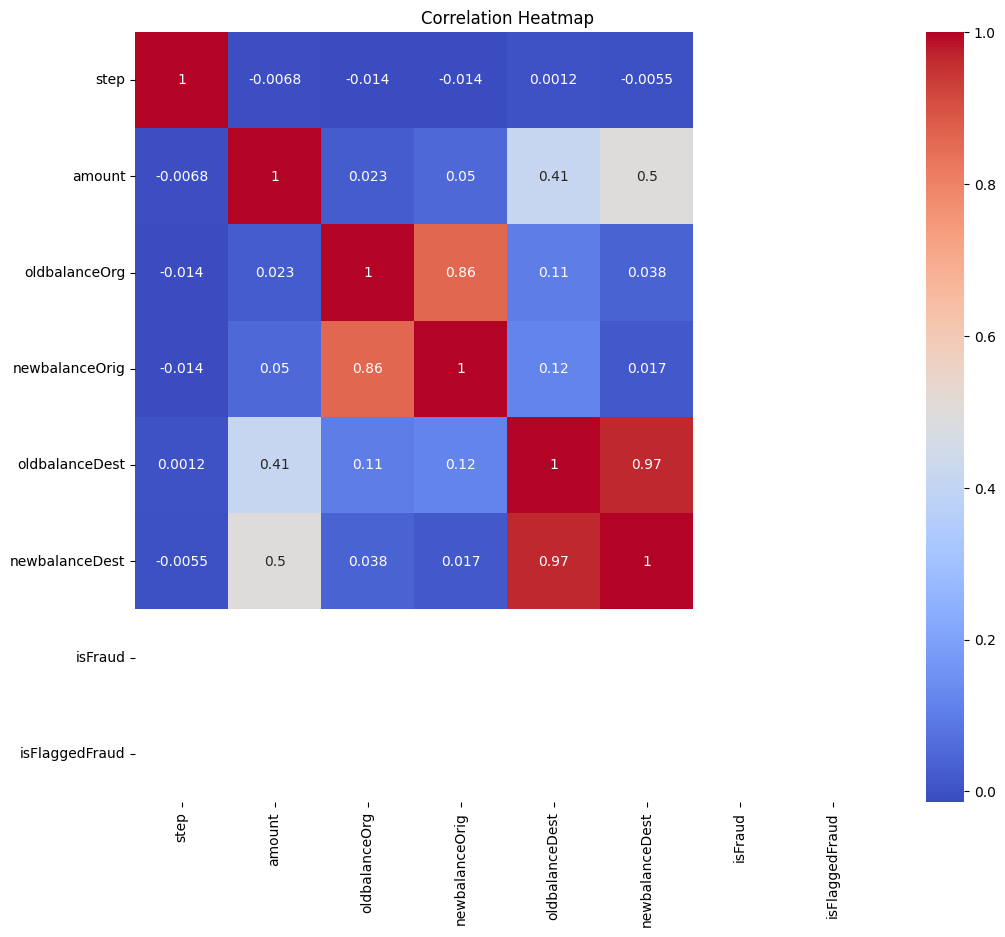

In [ ]:
# Install necessary libraries (if running in Colab or first time)
!pip install xgboost imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load the dataset
df = pd.read_csv('/content/Fraud.csv', sep=',', on_bad_lines='skip') # Added sep and on_bad_lines

# ----------------------------
# 1️⃣ Data Cleaning
# ----------------------------

# Handle missing values
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Remove duplicates
df = df.drop_duplicates()

# Outlier capping using IQR
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

# Handle multicollinearity
# Drop non-numeric columns before calculating correlation
df_numeric = df.drop(columns=['nameOrig', 'nameDest', 'type'], errors='ignore') # Excluded 'type' column
plt.figure(figsize=(12,10))
corr_matrix = df_numeric.corr() # Calculate correlation on numeric data
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df = df.drop(columns=to_drop)

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Feature Scaling
scaled_cols = df.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

# ----------------------------
# 2️⃣ Split Data into X & y
# ----------------------------

# Replace 'isFraud' with your actual target column name
target = 'isFraud'  # Change this if your target column is named differently
X = df.drop(target, axis=1)
y = df[target]

# ----------------------------
# 3️⃣ Handle Imbalanced Data using SMOTE
# ----------------------------
from collections import Counter
print("Original class distribution:", Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("Balanced class distribution after SMOTE:", Counter(y_res))

# ----------------------------
# 4️⃣ Train-Test Split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# ----------------------------
# 5️⃣ Train XGBoost Classifier
# ----------------------------
model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, scale_pos_weight=1)
model.fit(X_train, y_train)

# ----------------------------
# 6️⃣ Model Evaluation
# ----------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='XGBoost (AUC = %.3f)' % roc_auc_score(y_test, y_prob))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='XGBoost PR Curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# ----------------------------
# 7️⃣ Feature Importance
# ----------------------------
importances = model.feature_importances_
feat_names = X.columns

importance_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Important Features")
plt.show()